In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

In [21]:
class Point:
    def __init__(self, x, y):
        self._x = x
        self._y = y
    
    def distance(self, to):
        dx = abs(self._x - to._x)
        dy = abs(self._y - to._y)
        distance = np.sqrt(dx ** 2 + dy ** 2)
        return distance
    
    def __repr__(self):
        return f'({self._x}, {self._y})'

In [247]:
class TSP:
    def __init__(self, points):
        self._points = points
        self._num_of_points = len(points)
        self._best_distances = []
        self._best_solution = None
       
    def plot_progress(self):
        plt.plot(self._best_distances)
        plt.ylabel('Distance')
        plt.xlabel('Generation')
        plt.show()
        
    def find_solution(self, generations=100, psize=50, elite_part=0.6):
        population = self.__get_initial_population(psize)
        for _ in range(generations):
            print(f'Done: {100 * (_ + 1) / generations:.2f}%', end='\r')
            population = self.__get_next_generation(population, elite_part)
        print()
        return self._best_solution
    
    def __mutate(self, route, prob=0.05):
        for p1 in range(self._num_of_points - 1):
            p2 = np.random.randint(p1 + 1, self._num_of_points)
            if np.random.random() < prob:
                route[p1], route[p2] = route[p2], route[p1]
        return route
    
    def __get_mutated_population(self, population):
        mutated_population = []
        for route in population:
            mutated_population.append(self.__mutate(route))
        return mutated_population
    
    def __crossover(self, parent1, parent2):
        left = np.random.randint(0, self._num_of_points)
        right = np.random.randint(left + 1, self._num_of_points + 1)
        child = list(parent1[left:right])
        used = set(child)
        child += [pt for pt in parent2 if pt not in used]
        return child
    
    def __get_crossover_population(self, population, ranks, elite_size):
        inds = [r[0] for r in ranks]
        probs = softmax(np.array([-r[1] / 100000 for r in ranks]))
        pool = inds[:elite_size]
        pool += list(np.random.choice(inds, len(population) - elite_size, p=probs))
        crossover_population = []
        for i in range(len(population)):
            crossover_population.append(self.__crossover(population[pool[i - 1]], population[pool[i]]))
        return crossover_population
    
    def __get_next_generation(self, population, elite_part):
        ranks = self.__get_ranks_of_population(population)
        self._best_distances.append(ranks[0][1])
        if not self._best_solution or ranks[0][1] < self._best_solution['distance']:
            self._best_solution = {'route': population[ranks[0][0]], 'distance': ranks[0][1]}
        population = self.__get_crossover_population(population, ranks, elite_size=int(elite_part * len(population)))
        population = self.__get_mutated_population(population)
        return population
        
    def __compute_route_distance(self, route):
        if len(route) != self._num_of_points:
            raise ValueError("Route length doesn't match with number of points.")
        distance = 0
        for i in range(self._num_of_points):
            distance += self._points[route[i]].distance(self._points[route[i - 1]])
        return distance
    
    def __generate_route(self):
        return np.random.permutation(self._num_of_points)

    def __get_initial_population(self, psize):
        population = []
        for _ in range(psize):
            population.append(self.__generate_route())
        return population
    
    def __get_ranks_of_population(self, population):
        ranks = []
        for ind, route in enumerate(population):
            rank = (ind, self.__compute_route_distance(route))
            ranks.append(rank)
        return sorted(ranks, key=lambda rank: rank[1])

In [253]:
TEST_FILE_NAME = './data/tsp_100_3'

In [254]:
with open(TEST_FILE_NAME, 'r') as f:
    data = f.readlines()

In [255]:
n_points, *points = data
n_points = int(n_points)
points = [Point(*map(float, p.split())) for p in points]

Done: 100.00%


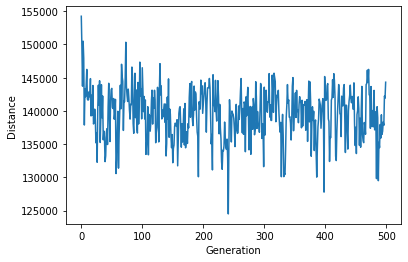

124499.37442980058


In [256]:
solver = TSP(points)
solution = solver.find_solution(generations=500, psize=100, elite_part=.2)
solver.plot_progress()
print(solution['distance'])

In [203]:
with open('out.txt', 'w') as f:
    f.write(' '.join(map(str, solution['route'])))